In [48]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import math

import warnings
warnings.filterwarnings('ignore')

data_dir = "../data"
print(os.listdir(data_dir))

['group_match_data_train_non_norm.zip', 'group_match_data_train_norm.zip', 'train_V2.csv.zip', 'test_V2.csv.zip']


# load preprocessed data 

team & match data from saved file.

In [69]:
group_match_data = \
pd.read_csv(os.path.join(data_dir,'group_match_data_train_norm.zip'))

In [71]:
# group_match_data['winPlacePerc'][group_match_data['winPlacePerc'].isnull()==True]
group_match_data = group_match_data.dropna()

In [72]:
group_match_data['matchType'].unique().tolist()

['squad-fpp', 'duo-fpp', 'solo-fpp', 'solo', 'squad', 'duo']

In [73]:
len(group_match_data)

1867964

In [74]:
group_match_data.keys()

Index(['groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'healsandboosts',
       'headshot_rate', 'totalDistance', 'team_mode', 'damage_per_enemy',
       'avg_walk_speed', 'player_count', 'matchType_onehot_duo',
       'matchType_onehot_duo-fpp', 'matchType_onehot_solo',
       'matchType_onehot_solo-fpp', 'matchType_onehot_squad',
       'matchType_onehot_squad-fpp', 'totalDistancePlace'],
      dtype='object')

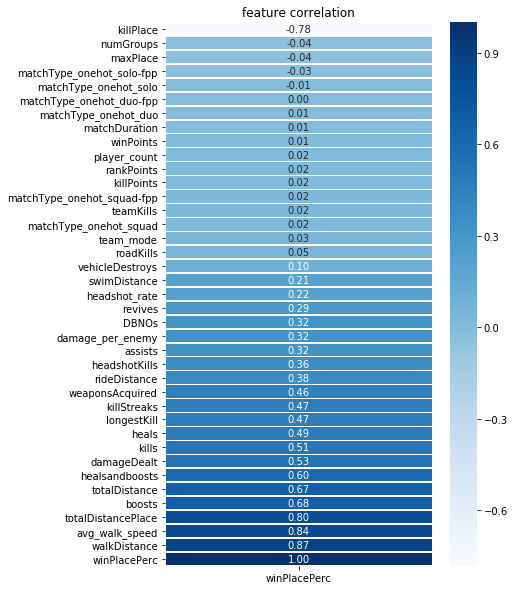

In [75]:
corr=group_match_data.corr()
Y_Column = 'winPlacePerc'
corr_Target = corr[[Y_Column]]
x = 0
corr_T= corr_Target[abs(corr_Target['winPlacePerc'])>x]
corr_T = corr_T.sort_values(by='winPlacePerc')
fig = plt.figure(figsize=(6, 10))
# f,ax = plt.subplots()
sns.heatmap(corr_T, annot=True, linewidths=.5, fmt= '.2f', cmap=plt.cm.Blues)
plt.title("feature correlation",fontsize=12)
fig.show()

In [76]:
len(group_match_data)

1867964

In [77]:
# scaler = StandardScaler()
# scaler.fit_transform(group_match_data)

# model training

## Common Functions

In [78]:
def fill_missing(train_feature_no_obj):
    # fill missing value with most_frequent
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent', verbose=0, copy=False)
    imputer.fit(train_feature_no_obj)
    train_feature_no_obj = imputer.transform(train_feature_no_obj)
    return train_feature_no_obj

def split_data(data, X_Column, Y_Column, is_norm=True):
    
    matchids = data['matchId'].unique()
    matchids.sort()
    split_position = matchids[len(matchids) // 3]
    
    train = data.query(f'matchId >= "{split_position}"')#.head()
    test = data.query(f'matchId < "{split_position}"')#.head()
    
    X_train = train[X_Column]
    Y_train = train[Y_Column]

    X_test = test[X_Column]
    Y_test = test[Y_Column]
    
    if is_norm:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)
    
    return X_train, X_test, Y_train, Y_test

def train_and_cross_vali(model_name, model, X, y, n_jobs=4):
    scores = cross_val_score(model, X, y, cv=10, n_jobs=n_jobs, scoring=make_scorer(mean_absolute_error))
    score = scores.mean()
    print(f"{model_name} crossvali score: {score}")

## Linear Regression

In [79]:
corr= group_match_data.corr()
corr_T = corr[['winPlacePerc']]
corr_T.query('abs(winPlacePerc) > 0.2').index.tolist()

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'revives',
 'rideDistance',
 'swimDistance',
 'walkDistance',
 'weaponsAcquired',
 'winPlacePerc',
 'healsandboosts',
 'headshot_rate',
 'totalDistance',
 'damage_per_enemy',
 'avg_walk_speed',
 'totalDistancePlace']

In [186]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error

def train_mode(mode="solo-fpp", is_filter_mode=True, data=group_match_data):

    if is_filter_mode:
        df_train = group_match_data.query(f'matchType == "{mode}"')
    else:
        df_train = group_match_data

    Y_Column = 'winPlacePerc'

    corr= df_train.corr()
    corr_T = corr[[Y_Column]]
#     X_Column = corr_T.query('abs(winPlacePerc) > 0.2').index.tolist()
#     X_Column.remove(Y_Column)

    X_Column = ['assists',
         'boosts',
         'damageDealt',
         'DBNOs',
         'headshotKills',
         'heals',
         'killPlace',
         'kills',
         'killStreaks',
         'longestKill',
         'revives',
         'rideDistance',
         'swimDistance',
         'walkDistance',
         'weaponsAcquired',
         'healsandboosts',
         'headshot_rate',
         'damage_per_enemy',
         'avg_walk_speed',
         'totalDistancePlace']

    if not is_filter_mode:
        X_Column.extend(['matchType_onehot_duo',
         'matchType_onehot_duo-fpp', 
         'matchType_onehot_solo',
         'matchType_onehot_solo-fpp',           
         'matchType_onehot_squad',
         'matchType_onehot_squad-fpp'])

    
    X_train, X_test, Y_train, Y_test = train_test_split(df_train[X_Column], df_train[Y_Column], test_size= 0.3, random_state= 0) 
    #split_data(df_train, X_Column, Y_Column, is_norm=False)
    
    model = Ridge(alpha=0.1)
    model.fit(X_train, Y_train)
    y_pred= model.predict(X_test)

    M = mean_absolute_error(Y_test, y_pred)
    if is_filter_mode:
        print(f'mode: {mode}, Mean Absolute Error : {M}')
    else:
        print(f'Mean Absolute Error : {M}')

**train model for different modes**

In [187]:
modes = group_match_data.matchType.unique().tolist()

In [188]:
modes

['squad-fpp', 'duo-fpp', 'solo-fpp', 'solo', 'squad', 'duo']

Try:
1. single player as one mode.
2. team as one mode.

In [189]:
len(modes)

6

In [190]:
for mode in modes:
    train_mode(mode)

mode: squad-fpp, Mean Absolute Error : 0.07493442019888659
mode: duo-fpp, Mean Absolute Error : 0.07232253301763122
mode: solo-fpp, Mean Absolute Error : 0.06340472734744966
mode: solo, Mean Absolute Error : 0.06629391959590655
mode: squad, Mean Absolute Error : 0.08165451337953206
mode: duo, Mean Absolute Error : 0.07545028504514889


**encode matchType using onehot. and train all**

In [191]:
# enc = OneHotEncoder(handle_unknown='ignore')
# o = enc.fit_transform(group_match_data['matchType'].values.reshape(-1,1)).toarray()
# o2 = pd.DataFrame(o)
# data_enc = group_match_data.join(o2)
# # data.rename(index=int, columns={0:'p0', 1:'p1', 2:'p2', 3:'p3'}, inplace=True)

In [192]:
# encode_data = group_match_data.drop('matchType', axis=1, inplace=False)

In [193]:
train_mode(data=group_match_data, is_filter_mode=False)

Mean Absolute Error : 0.07804337957675728


## SVM

In [194]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer

In [230]:
def train_mode(mode="solo-fpp", is_filter_mode=True, data=group_match_data):

    if is_filter_mode:
        df_train = group_match_data.query(f'matchType == "{mode}"')
    else:
        df_train = group_match_data
     
    Y_Column = 'winPlacePerc'    

    corr= df_train.corr()
    corr_T = corr[[Y_Column]]
#     X_Column = corr_T.query('abs(winPlacePerc) > 0.2').index.tolist()
#     X_Column.remove(Y_Column)
#     if 'matchType' in X_Column:
#         X_Column.remove('matchType')
    X_Column = ['assists',
     'boosts',
     'damageDealt',
     'DBNOs',
     'headshotKills',
     'heals',
     'killPlace',
     'kills',
     'killStreaks',
#      'longestKill',
     'revives',
#      'rideDistance',
#      'swimDistance',
     'walkDistance',
     'weaponsAcquired',
     'healsandboosts',
     'headshot_rate',
     'damage_per_enemy',
     'avg_walk_speed',
     'totalDistancePlace']#,
    
    if not is_filter_mode:
        X_Column.extend(['matchType_onehot_duo',
         'matchType_onehot_duo-fpp', 
         'matchType_onehot_solo',
         'matchType_onehot_solo-fpp',           
         'matchType_onehot_squad',
         'matchType_onehot_squad-fpp'])

#     X_train, X_test, Y_train, Y_test = split_data(df_train, X_Column, Y_Column, is_norm=True)
    X_train, X_test, Y_train, Y_test = train_test_split(df_train[X_Column], df_train[Y_Column], test_size= 0.3, random_state= 0) 
    
    model = SVR(C=100.0, epsilon=0.5, max_iter=200, cache_size=500, gamma=3)#, kernel='poly', degree=3)
    model.fit(X_train, Y_train)
    y_pred= model.predict(X_test)
    M = mean_absolute_error(Y_test, y_pred)
    
    if is_filter_mode:
        print(f'mode: {mode}, Mean Absolute Error : {M}')
    else:
        print(f'Mean Absolute Error : {M}')

In [231]:
modes = group_match_data.matchType.unique().tolist()

In [232]:
for mode in modes:
    train_mode(data=group_match_data, mode=mode)

mode: squad-fpp, Mean Absolute Error : 0.2572903637403779
mode: duo-fpp, Mean Absolute Error : 0.25506002733709776
mode: solo-fpp, Mean Absolute Error : 0.2532349589964328
mode: solo, Mean Absolute Error : 0.2534992444063042
mode: squad, Mean Absolute Error : 0.254875238717565
mode: duo, Mean Absolute Error : 0.2564198187062217


In [198]:
# %time
# train_and_cross_vali('svr', model, X_data, Y_data, n_jobs=8)

In [199]:
# enc = OneHotEncoder(handle_unknown='ignore')
# o = enc.fit_transform(group_match_data['matchType'].values.reshape(-1,1)).toarray()
# o2 = pd.DataFrame(o)
# data_enc = group_match_data.join(o2)
# # data.rename(index=int, columns={0:'p0', 1:'p1', 2:'p2', 3:'p3'}, inplace=True)

In [200]:
# encode_data = group_match_data.drop('matchType', axis=1, inplace=False)

In [204]:
train_mode(data=group_match_data, is_filter_mode=False)

Mean Absolute Error : 0.24529099564369722
